In [1]:
include("/Users/gr_1/Documents/lemur/julia/run_lemur.jl")
include("/Users/gr_1/Documents/isoflex/IsoFlex.jl")
#using Plots
lemur_params = lemur_obj();
using JLD

In [2]:
#using Plots

In [4]:
function dt(t)
    r_ = 100
    a = 1e-5
    m = 500
    n = 500
    U=zeros(m,n)
    for i = 1:m
        for j=1:n
            r = sqrt((Float64(i-m/2.00)^2+Float64(j-n/2.00)^2))
            U[i,j] = a * exp(-r^2/r_^2)

        end
    end
    return U
end

dt (generic function with 1 method)

In [5]:
2500 * 2700 /1e6

6.75

In [3]:
function Isovary(t)
    dT = 30e6 #1/2 cycle duration
    tu = floor(t/dT)
    dt = 1e6
    if mod(tu,2) == 1
       c1 = 1-(t-dT*tu)/dT
       c2 = 1-(t+dt-dT*tu)/dT
    else
       c1 = (t-dT*tu)/dT
       c2 = (t+dt-dT*tu)/dT
    end

    W = zeros(500,500)
    W[200:300, 100:400] .= 1500
    W[250:300, 100:400] .= -1500

    U1 = IsoFlex.flexural(W, Nx = 0, Ny = -3500*2750*1e6*9.81*c1, dx=1000, dy=1000, Te = 30e3, ncores=1);
    U2 = IsoFlex.flexural(W, Nx = 0, Ny = -3500*2750*1e6*9.81*c2, dx=1000, dy=1000, Te = 30e3, ncores=1);

    return (U2-U1)/dt
end

Isovary (generic function with 1 method)

In [4]:
3500*2750*1e6*9.81

9.442125e13

In [5]:
function Isovary_total(t)
    dT = 30e6 #1/2 cycle duration
    tu = floor(t/dT)
    dt = 1e6
    if mod(tu,2) == 1
       c1 = 1-(t-dT*tu)/dT 
       c2 = 1-(t+dt-dT*tu)/dT 
    else
       c1 = (t-dT*tu)/dT 
       c2 = (t+dt-dT*tu)/dT
    end
    ny = 500
    nx = 500
    dx = 1000
    dy = 1000
    W = zeros(ny,nx)
    W[200:300] .= 1500
    W[200:250, 200:300] .= -1500

    U1 = IsoFlex.flexural(W, Nx = 0, Ny = -3500 * 2750 * 1e6 * 9.81*c1, dx=dx, dy=dy, Te = 25e3, ncores=1);
    U2 = IsoFlex.flexural(W, Nx = 0, Ny = -3500 * 2750 * 1e6 * 9.81*c2, dx=dx, dy=dy, Te = 25e3, ncores=1);
    println(c1)
    return U1
end

Isovary_total (generic function with 1 method)

In [10]:
G = zeros(100,100)
d = 1000.
dx = 10000.
G[40:60,20:80] .= -d .* dx .^ 2 * 2750.
G[40:50,20:80] .= d .* dx .^ 2 * 2750.
z = 10000.
g=zeros(100, 100)
Threads.@threads for i1 = 1:100
    for j1 = 1:100
        for i = 1:100
             for j = 1:100
                r2 = ((i1 + .3 - float(i)) * dx) .^ 2 + ((j1 + .3 - float(j)) * dx) .^ 2. #.3 is avg distance to center from any point of square
                #deg = z / (sqrt(r2 + z^2))
                g[i1,j1] += (z + d/2) / (r2 + z^2+(d/2)^2) .^ 1.500 * G[i,j] * 7e-11 
            end
        end
    end
    print(i1)
end

123

TaskFailedException: [91mTaskFailedException:[39m
[91m[91mInterruptException:[39m[39m
[91mStacktrace:[39m
[91m [1] [1mBroadcasted[22m at [1m./broadcast.jl:170[22m [inlined][39m
[91m [2] [1mBroadcasted[22m at [1m./broadcast.jl:179[22m [inlined] (repeats 2 times)[39m
[91m [3] [1mbroadcasted[22m at [1m./broadcast.jl:1239[22m [inlined][39m
[91m [4] [1mbroadcasted[22m[1m([22m::Function, ::Function, ::Float64, ::Val{2}[1m)[22m at [1m./broadcast.jl:1237[22m[39m
[91m [5] [1mmacro expansion[22m at [1m./In[10]:12[22m [inlined][39m
[91m [6] [1m(::var"#133#threadsfor_fun#6"{UnitRange{Int64}})[22m[1m([22m::Bool[1m)[22m at [1m./threadingconstructs.jl:61[22m[39m
[91m [7] [1m(::var"#133#threadsfor_fun#6"{UnitRange{Int64}})[22m[1m([22m[1m)[22m at [1m./threadingconstructs.jl:28[22m[39m

In [1]:
#Zi2 = data_100[1].z[:,:,end]
#save("./Zi3.jld", "Zi", Zi2)

Zi = load("Zi2.jld","Zi");

UndefVarError: [91mUndefVarError: load not defined[39m

In [8]:
## Compare too variable thing

In [ ]:
include("/Users/gr_1/Documents/lemur/julia/run_lemur.jl")
lemur_params = lemur_obj()
lemur_params.t_c = 0e6
lemur_params.dt = 1e6
lemur_params.flex = 30e6
lemur_params.kd=.001
lemur_params.l = 10 #really need to be float - check
lemur_params.undercapacity = ones(500,500)
lemur_params.m = .5
lemur_params.n = 1.0
#lemur_params.z = lemur_params.z+rand(500,500)
lemur_params.t = 500e6
#lemur_params.z = Zi#copy(data_100[1].z[:,:,1])
#lemur_params.k[1:250,:] .= 8e-7
lemur_params.k[:,:] .= 1e-6 
bcx = zeros(500,500)
bcx[:,1] .= 1
lemur_params.ks = 1e-6
bcx[end,:] .= 1
bcx[1,:] .= 1
bcx[:,end] .= 1
lemur_params.bcx = bcx
lemur_params.bc = findall(vec(bcx .== 1))
#lemur_params.ufunc = Isovary
lemur_params.u = zeros(500,500).+.000002
lemur_params.uselandsed = 2
lemur_params.maxareasinkfill = .000
lemur_params.precip = .5
lemur_params.evaprate = 1.0
data_100 = run_lemur.run(lemur_params,compute_sedflux=true);

In [1]:
include("/Users/gr_1/Documents/lemur/julia/run_lemur.jl")
lemur_params = lemur_obj()
lemur_params.t_c = 0e6
lemur_params.dt = 1e6
lemur_params.flex = 30e6
lemur_params.kd=.001
lemur_params.l = 10 #really need to be float - check
lemur_params.undercapacity = ones(500,500)
lemur_params.m = .5
lemur_params.n = 1.0
#lemur_params.z = lemur_params.z+rand(500,500)
lemur_params.t = 500e6
lemur_params.z = Zi#data_100[1].z[:,:,end]#Zi#copy(data_100[1].z[:,:,1])
#lemur_params.k[1:250,:] .= 8e-7
lemur_params.k[:,:] .= 1e-6 
bcx = zeros(500,500)
bcx[:,1] .= 1
lemur_params.ks = 1e-6
bcx[end,:] .= 1
bcx[1,:] .= 1
bcx[:,end] .= 1
lemur_params.bcx = bcx
lemur_params.bc = findall(vec(bcx) .== 1)
lemur_params.ufunc = Isovary
lemur_params.u = zeros(500,500).+.000002
lemur_params.uselandsed = 2
lemur_params.maxareasinkfill = .0000
lemur_params.precip = .5
lemur_params.evaprate = 1.0
data_100 = run_lemur.run(lemur_params,compute_sedflux=true);

UndefVarError: [91mUndefVarError: Zi not defined[39m

In [26]:
# anim = @animate for i = 1:5:length(data_100[3])
#     plot(data_100[1].z[:,:,i][Array{Int32}(data_100[3][i])], ylims=(-50,50))
# end 
# gif(anim, "/users/gr_1/Downloads/anim_fps15.gif", fps = 15)

001.0
000.03333333333333333


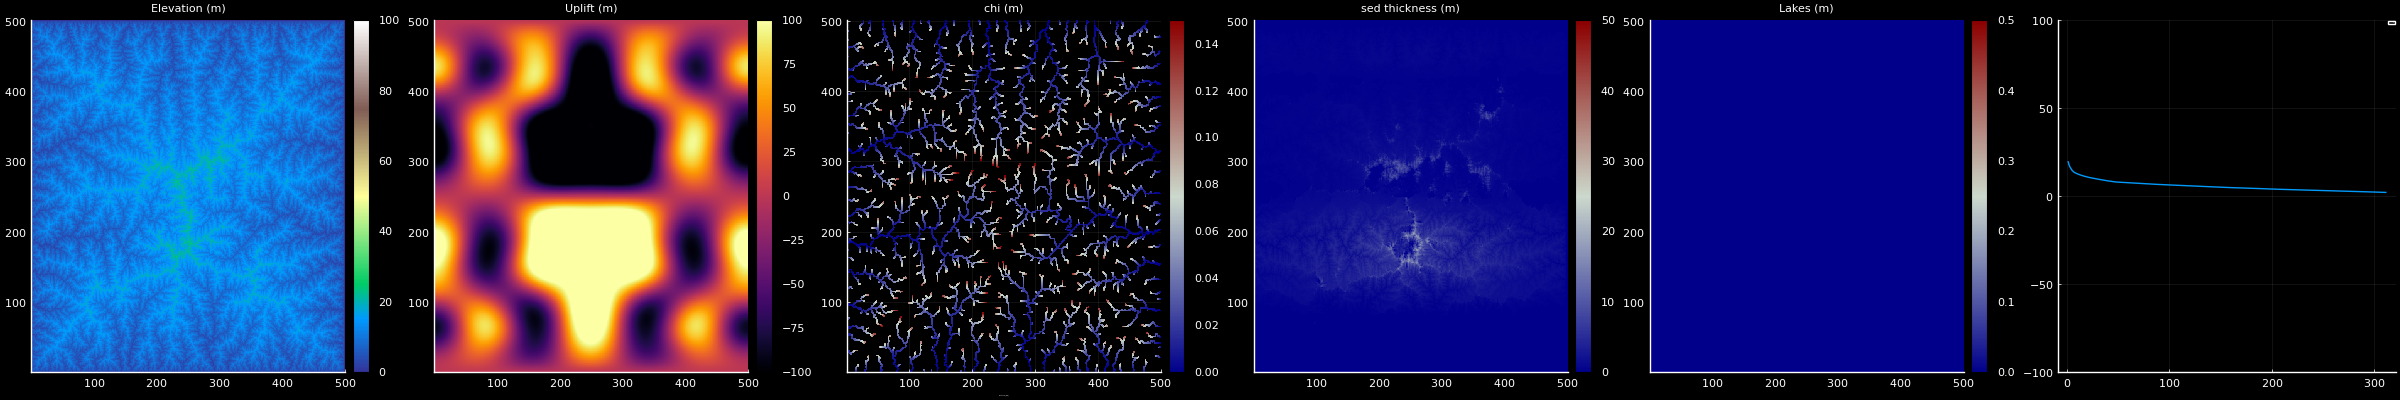

In [73]:
using Plots
pyplot()
ti = 450
Plots.scalefontsizes(1/10)
ch = copy(data_100[1].chi[:,:,ti])
s = copy(data_100[1].csed[:,:,ti])
w= copy(data_100[1].cw[:,:,ti])
idx = Array{Int32}(data_100[3][ti])
profile = data_100[1].z[:,:,ti][idx]
a = copy(data_100[1].a[:,:,ti])
ch[a .< 100] .= NaN
    plt = plot(
    heatmap((data_100[1].z[:,:,ti]),clim=(0,100),c= cgrad(:terrain,[.25,.5,.75], rev = false),title="Elevation (m)"),
    heatmap(Isovary_total(ti*1e6) - Isovary_total(1*1e6), clim=(-100,100),title="Uplift (m)"),
    heatmap(ch,c= cgrad(:bluesreds,[.5], rev = false),clim=(.0,.15), bgcolor=:black, title="chi (m)",
                xaxis = ("Distance (km)")),heatmap(s,c= cgrad(:bluesreds,[.5], rev = false),clim=(.0, 50), bgcolor=:black,size=(1400, 400), title="sed thickness (m)"),
    heatmap(w,c= cgrad(:bluesreds,[.5], rev = false),clim=(.0, .5), bgcolor=:black,size=(2400, 400), title="Lakes (m)"),
    plot(profile, ylims=(-100,100),bgcolor=:black,size=(2400, 400)),
    layout=grid(1,6),titlefontsize=8,xtickfontsize=8,ytickfontsize=8)
    #annotate!(200, 480, text("Time = " * string(ti) * " Myr", :black, :left, 20))

00

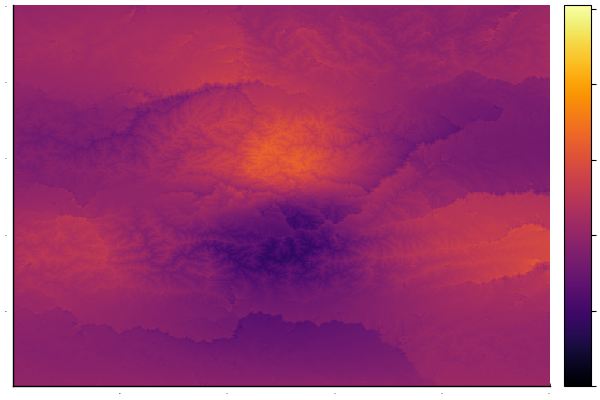

In [11]:
heatmap(data_100[1].z[:,:,ti] - Zi - Isovary_total(10) .- .000002*ti*1e6, clim=(-100,1) )

## Vertical load and in plane stress variations - what values, what timescales?
### Right now using Arbritrary - ~70 m of uplift over 30 Ma
## Evidence of capture in fink?
## Low precip and ero - basin doesn't stay isolated very long
## Finke profile modeling
## timing from finke
## missionary plains sediment - compare
## 1 cycle - how disequilibrated, where are we in the current cycle?

In [263]:
l = @layout [a b c; d g e]


Plots.GridLayout(2, 3)

In [ ]:
using Plots
pyplot()
Plots.scalefontsizes(.1)
anim = @animate for ti =1:5:length(data_100[1].z[1,1,:])
    l = @layout [a b c; d e f]

    ch = copy(data_100[1].chi[:,:,ti])
    a = copy(data_100[1].a[:,:,ti])
    s= copy(data_100[1].csed[:,:,ti])
    w= copy(data_100[1].cw[:,:,ti])
    idx = Array{Int32}(data_100[3][ti])
    profile = data_100[1].z[:,:,ti][idx]
    ch[a .<100] .= NaN
    p1 = heatmap((data_100[1].z[:,:,ti]),clim=(-50,100),c= cgrad(:terrain,[.25,.5,.75], rev = false),title="Elevation (m)")
    p1 = plot!(round.((Array{Float64}(idx) .- 1.) / 500) .+1 , Array{Float64}(idx .% 500) )
    p2 = heatmap(Isovary_total(ti*1e6), clim=(-200,200),title="Uplift (m)")
    p3 = heatmap(ch,c= cgrad(:bluesreds,[.5], rev = false),clim=(.0,.15), bgcolor=:black, title="chi (m)",xaxis = ("Distance (km)"))
    p4 = heatmap(s,c= cgrad(:bluesreds,[.5], rev = false),clim=(.0, 50), bgcolor=:black, title="sed thickness (m)")
    p5 = heatmap(w,c= cgrad(:bluesreds,[.5], rev = false),clim=(.0, 3), bgcolor=:black, title="Lakes (m)") 
    p6 = plot(profile, ylims=(-50,50))
    
    p6 = annotate!(200, 480, text("Time = " * string(ti) * " Myr", :black, :left))
    plot(p1,p2,p3,p4,p5,p6,layout=l,size=(1200, 1200),titlefontsize=8,xtickfontsize=8,ytickfontsize=8,fontcolor=:white)

end
gif(anim, "./anim_fps15.gif", fps = 7)


In [91]:
function downprof(Z,R,i,j,t)

    z = zeros(0)
    d = zeros(0)
        ij = i + (j-1) * m
        c=1
        while(R[i,j,t] != ij)
            ij =R[i,j,t]
            i2 = Int16((ij-1)%m +1)
            j2 = Int16(floor((ij-1)/m)+1)
            append!(d,((i-i2).^2 .+ (j-j2).^2).^.5)
            append!(z, (Z[i2, j2, t+1] - Z[i2,j2,t] - Isovary(t+1)[i2,j2]*1e6))
            i=i2
            j=j2
            c+=1
        end
    return(d,z)
end

downprof (generic function with 2 methods)

In [ ]:
dd = 5
m,n,ti = size(data_100[1].R)
anim = @animate for d = 1:dd:500
    d,z = downprof(data_100[1].z,data_100[1].R,350,250,d)
    plot(cumsum(d),z)
    ylims!((-2,2))
    xlims!((0,100))
end
gif(anim, "anim_fps152.gif", fps = 7)


In [ ]:
for t = 1:dd:ti


In [ ]:
using Plots
pyplot()
a = zeros(length(data_100[1].u2[1,1,:]))
for i = 1:length(data_100[1].u2[1,1,:])
    a1  = 
    a[i] = sum(data_100[1].u2[3,:,i] /1e3 *2)
end
plot(0:.5:200,a,ylims=(0,3e4),legend=false,linewidth=3,xlabel = "Model run time (Myr)",ylabel="Sediment flux to southern margin ( km3 / Myr )" )
plot!(65:.1:65.1,0:3e4:3e4)

In [ ]:
plot(log.(a1[a1.>0]))

In [70]:
using Statistics
maximum(vec(data_100[1].u2[:,:,100]))

189.3223709094582

In [ ]:
using Plots
a = zeros(length(data_100[1].u2[1,1,:]))
a1 = zeros(500)
for i = 1:length(data_100[1].u2[1,1,:])
    a1[:] .= data_100[1].u2[3,:,i]

    a[i] = sum(data_100[1].u2[3,:,i])
end
plot(0:.5:200,a,ylims=(0,1e7),legend=false,linewidth=3)

In [ ]:
lemur_params = lemur_obj()
lemur_params.t_c = 1e6
lemur_params.dt = .5e6
lemur_params.t = 200e6
lemur_params.flex = 40e3
lemur_params.k[:,:] .= 5e-7
lemur_params.z[1:250,:] .-= 2000
data_5 = run_lemur.run(lemur_params)

In [ ]:
lemur_params.t_c = 300e6
lemur_params.dt = .5e6
lemur_params.t = 50e6
lemur_params.flex = 40e3
lemur_params.k[:,:] .= 5e-7
lemur_params.z[1:250,:] .-= 2000
data_50_demo = run_lemur.run(lemur_params)

k undercapacity z dx 1000.0
here2 2 
dy 1000.0
here2 3 
t 5.0e7
here2dt 500000.0
here2display 1.0
here2Udt 2.3646297775e-314
here2flex 40000.0
here2kd 0.001
here2m 0.5
here2n 1.0
here2bc Float64[]
wdt 2.3625301803e-314
here2firstcall 1.0
here2u udt 100000.0
here2ny 500.0
here2nx 500.0
here2deposit 0.0
here2srho 2400.0
here2drawdt 2.3671589904e-314
here2l 10.01
here2ks 0.1
here2t_c 3.0e8
here2sinkfill 1.0
here2uselandsed 2.0
here2maxareasinkfill 0.0
here2precip 0.5
here2evaprate 1.0
here2bcx k_sed 5.0e-7

In [ ]:
data = data_100
@gif for t = 2:30:size(data[1].z)[3]
plt = plot(
    heatmap(data[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false)  ,
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,2500),title="Elevation (m)"),
    heatmap(data[1].chi[:,:,t],
    xaxis = ("Distance (km)"),yaxis = ("Distance (km)"), clim=(.5,1),title="Swath Elevation (m)"  ), layout=grid(1, 2),
    size=(1000,1500))
   
annotate!(200, 480, text("Time = " * string(t/2) * " Myr", :black, :left, 20),)
end



In [27]:
using Plots
using Statistics
gr()
#font = Plots.font("Helvetica", 18, weight= "light")
#pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
data = data_100
@gif for t = 2:30:size(data[1].z)[3]
plt = plot(
    heatmap(data[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false)  ,
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,2500),title="Elevation (m)"),
    heatmap(data[1].u[:,:,t]*2,c= cgrad(:RdBu_10,[.1], rev = true)  ,
    xaxis = ("Distance (km)"),clim=(-3,30),title="Uplift rate (m/Myr)",yaxis = false),
    heatmap(mean(data[1].chi[:,:,t],dims=2),linewidth=2,
    xaxis = ("Distance (km)"),yaxis = false, ylim=(0,2500),title="Swath Elevation (m)"  ), layout=grid(1, 3),
    size=(2000,1500))
   
annotate!(200, 480, text("Time = " * string(t/2) * " Myr", :black, :left, 20),)
end



Base.IOError: [91mIOError: cwd: operation not permitted (EPERM)[39m

In [75]:
anim()

31

In [ ]:
using Plots
gr()
#font = Plots.font("Helvetica", 18, weight= "light")
#pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
data = data_5

@gif for t = 2:5:401
plt = plot(
    heatmap(data[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false)  ,
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,2500),title="Elevation (m)"),
    heatmap(data[1].u[:,:,t]*2,c= cgrad(:RdBu_10,[.1], rev = true)  ,
    xaxis = ("Distance (km)"),clim=(-3,30),title="Uplift rate (m/Myr)",yaxis = false),
    heatmap(data[1].z[:,:,t-1]*2 - data[1].z[:,:,t]*2+data[1].u[:,:,t] .* 2,c= cgrad(:RdBu_10,[.1], rev = true)  ,
    xaxis = ("Distance (km)"),yaxis = false, clim=(-6,60),title="Erosion rate (m/Myr)"),
    plot(mean(data[1].z[:,:,t],dims=2),linewidth=2,
    xaxis = ("Distance (km)"),yaxis = false, ylim=(0,2500),title="Swath Elevation (m)"  ),layout=grid(2, 2),
    size=(2000,1500))
annotate!(200, 480, text("Time = " * string(t/2) * " Myr", :black, :left, 12))
end 

In [ ]:
data_5[1].u2

In [ ]:
using Plots
gr()
#font = Plots.font("Helvetica", 18, weight= "light")
#pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
data = data_Inf

@gif for t = 2:5:401
plt = plot(
    plot(mean(data[1].z[:,:,t],dims=2),linewidth=2,
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),title="Elevation (m)",zlim=(0,2500)),
    plot(mean(data[1].z[:,:,t-1]-data[1].z[:,:,t]+data[1].u[:,:,t],dims=2),linewidth=2,
    xaxis = ("Distance (km)"),yaxis = false, ylim=(0,100),title="Erosion rate (m/Myr)"),layout=(1, 2))
    
annotate!(200, 10, text("Time = " * string(t/2) * " Myr", :black, :left, 12))
end 

In [ ]:
using Plots
gr()
#font = Plots.font("Helvetica", 18, weight= "light")
#pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
data = data_100

@gif for t = 2:5:401
plt = plot(
    plot(mean(data[1].z[:,:,t],dims=2)*2,linewidth=2,
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),title="Elevation (m)",ylim=(0,2500)),
    plot(mean(data[1].u[:,:,t],dims=2)*2,linewidth=2,
    xaxis = ("Distance (km)"),yaxis = false, ylim=(-5,15),title="Uplift rate (m/Myr)"),layout=(1, 2))
    
annotate!(200, 10, text("Time = " * string(t/2) * " Myr", :black, :left, 12))
end 

In [ ]:
using Plots
gr()
#font = Plots.font("Helvetica", 18, weight= "light")
#pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
data = data_50_demo

@gif for t = 2:5:101
plt = plot(
    plot(mean(data[1].z[:,:,t],dims=2)*2,linewidth=2,
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),title="Elevation (m)",ylim=(0,2500)),
    plot(mean(data[1].u[:,:,t],dims=2)*2,linewidth=2,
    xaxis = ("Distance (km)"),yaxis = false, ylim=(-5,15),title="Uplift rate (m/Myr)"),layout=(1, 2))
    
annotate!(200, 10, text("Time = " * string(t/2) * " Myr", :black, :left, 12))
end 

In [ ]:
using Plots
gr()
#font = Plots.font("Helvetica", 18, weight= "light")
#pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
data = data_Inf_demo

@gif for t = 2:5:101
plt = plot(
    plot(mean(data[1].z[:,:,t],dims=2)*2,linewidth=2,
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),title="Elevation (m)",ylim=(0,5000)),
    plot(mean(data[1].u[:,:,t],dims=2)*2,linewidth=2,
    xaxis = ("Distance (km)"),yaxis = false, ylim=(-5,15),title="Uplift rate (m/Myr)"),layout=(1, 2))
    
annotate!(200, 10, text("Time = " * string(t/2) * " Myr", :black, :left, 12))
end 

In [ ]:
using Plots
pyplot()
#font = Plots.font("Helvetica", 18, weight= "light")
pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
@gif for t = 1:5:401
data = data_Inf
plt = plot(
    heatmap(data[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false),size=(1500,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,2500),title="Elevation (m)"),
    heatmap(data[1].u[:,:,t]*2,c= cgrad(:RdBu_10,[.1], rev = true),size=(1500,500),
    xaxis = ("Distance (km)"),clim=(-3,30),title="Uplift rate (m/Myr)",yaxis = false),
    heatmap(data[1].z[:,:,t-1]*2 - data[1].z[:,:,t]*2+(data[1].u[:,:,t]*2),c= cgrad(:RdBu_10,[.1], rev = true),size=(1600,500),
    xaxis = ("Distance (km)"),yaxis = false, clim=(-60,600),title="Erosion rate (m/Myr)"),layout=(1,3))
annotate!(200, 480, text("Time = " * string(t/2) * " Myr", :black, :left, 12))
end 

In [ ]:
lemur_params.t_c = 100000000000000000000e6
data_Inf = run_lemur.run(lemur_params)

In [ ]:
using Plots
gr()
#font = Plots.font("Helvetica", 18, weight= "light")
#pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
data = data_Inf_demo

@gif for t = 2:5:101
plt = plot(
    plot(data[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false),size=(1500,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,2500),title="Elevation (m)"),
    heatmap(data[1].u[:,:,t]*2,c= cgrad(:RdBu_10,[.1], rev = true),size=(1500,1500),
    xaxis = ("Distance (km)"),clim=(-3,30),title="Uplift rate (m/Myr)",yaxis = false),
    heatmap(data[1].z[:,:,t-1]*2 - data[1].z[:,:,t]*2+data[1].u[:,:,t] .* 2,c= cgrad(:RdBu_10,[.1], rev = true),size=(1500,500),
    xaxis = ("Distance (km)"),yaxis = false, clim=(-6,60),title="Erosion rate (m/Myr)"),layout=(1, 3))
    
annotate!(200, 480, text("Time = " * string(t/2) * " Myr", :black, :left, 12))
end 

In [ ]:
using Plots
gr()
#font = Plots.font("Helvetica", 18, weight= "light")
#pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
data = data_50_demo

@gif for t = 2:5:101
plt = plot(
    heatmap(data[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false),size=(1500,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,2500),title="Elevation (m)"),
    heatmap(data[1].u[:,:,t]*2,c= cgrad(:RdBu_10,[.1], rev = true),size=(1500,1500),
    xaxis = ("Distance (km)"),clim=(-3,30),title="Uplift rate (m/Myr)",yaxis = false),
    heatmap(data[1].z[:,:,t-1]*2 - data[1].z[:,:,t]*2+data[1].u[:,:,t] .* 2,c= cgrad(:RdBu_10,[.1], rev = true),size=(1500,500),
    xaxis = ("Distance (km)"),yaxis = false, clim=(-6,60),title="Erosion rate (m/Myr)"),layout=(1, 3))
    
annotate!(200, 480, text("Time = " * string(t/2) * " Myr", :black, :left, 12))
end 

In [ ]:
#ont = Plots.font("Helvetica", 18, weight= "light")
pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
t = 401
data = data_100
plt = plot( 
    heatmap(data[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false),size=(1300,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,2500)),
    heatmap(data[1].u[:,:,t],c= cgrad(:RdBu_10,[.13], rev = true),size=(1300,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(-2,10)))


In [ ]:
lemur_params.t_c = 200e6
data_200 = run_lemur.run(lemur_params)

In [1]:
font = Plots.font("Helvetica", 18, weight= "light")
pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
t = 200
plt = plot( 
    heatmap(data_10[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false),size=(1300,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,300)),
    heatmap(data_10[1].u[:,:,t],c= cgrad(:RdBu_10,[.1], rev = true),size=(1300,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(-2,10)))


UndefVarError: [91mUndefVarError: Plots not defined[39m

In [ ]:
@gif
for i =1:5:401
heatmap(data[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false),size=(500,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,2500),title="Elevation (m)")
end


In [ ]:
font = Plots.font("Helvetica", 18, weight= "light")
pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
t = 1000
plt = plot( 
    heatmap(data_10[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false),size=(1300,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,2500)),
    heatmap(data_10[1].u[:,:,t],c= cgrad(:RdBu_10,[.1], rev = true),size=(1300,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(-2,10)))


In [ ]:
lemur_params.t_c = 100000000000000e6
data_inf = run_lemur.run(lemur_params)

In [90]:
#font = Plots.font("Helvetica", 18, weight= "light")
pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
t = 1000
data = data_100
plt = plot(
    heatmap(data[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false),size=(1300,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,300)),
    heatmap(data[1].u[:,:,t],c= cgrad(:RdBu_10,[.1], rev = true),size=(1300,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(-2,10)))

┌ Warning: Skipped font arg: font (typeof(font))
└ @ Plots /Users/gr_1/.julia/packages/Plots/uCh2y/src/args.jl:953
┌ Warning: Skipped font arg: font (typeof(font))
└ @ Plots /Users/gr_1/.julia/packages/Plots/uCh2y/src/args.jl:953
┌ Warning: Skipped font arg: font (typeof(font))
└ @ Plots /Users/gr_1/.julia/packages/Plots/uCh2y/src/args.jl:953
┌ Warning: Skipped font arg: font (typeof(font))
└ @ Plots /Users/gr_1/.julia/packages/Plots/uCh2y/src/args.jl:953
┌ Warning: Skipped font arg: font (typeof(font))
└ @ Plots /Users/gr_1/.julia/packages/Plots/uCh2y/src/args.jl:953
┌ Warning: Skipped font arg: font (typeof(font))
└ @ Plots /Users/gr_1/.julia/packages/Plots/uCh2y/src/args.jl:953


UndefVarError: [91mUndefVarError: data_Inf not defined[39m

In [ ]:
data_10

In [ ]:
function getswath(z)
        
end

In [21]:
z = data_50[1].z;

In [24]:
sumu = zeros([sizeof(z), t])

MethodError: [91mMethodError: no method matching zeros(::Array{Int64,1})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  zeros([91m::Union{Integer, AbstractUnitRange}...[39m) at array.jl:456[39m
[91m[0m  zeros([91m::Type{StaticArrays.SArray{Tuple{N},T,1,N} where T}[39m) where N at /Users/gr_1/.julia/packages/StaticArrays/rdb0l/src/SVector.jl:32[39m
[91m[0m  zeros([91m::Type{StaticArrays.MArray{Tuple{N},T,1,N} where T}[39m) where N at /Users/gr_1/.julia/packages/StaticArrays/rdb0l/src/MVector.jl:25[39m
[91m[0m  ...[39m

In [10]:
using Statistics

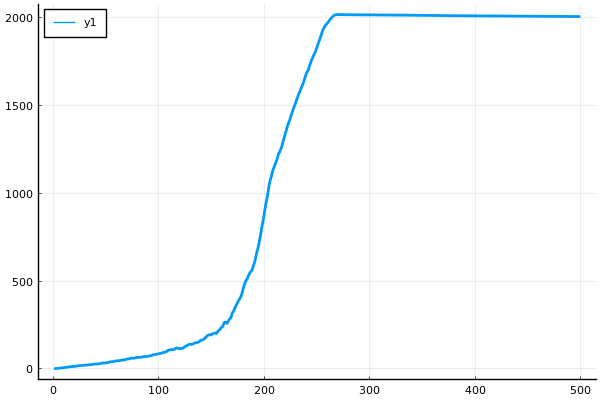

In [93]:
t = 201

plot(mean(data_100[1].z[:,:,t],dims=2),linewidth=2)
#plot!(mean(data_200[1].z[:,:,1000],dims=2),linewidth=2)
#plot!(mean(data_inf[1].z[:,:,t],dims=2),linewidth=2)

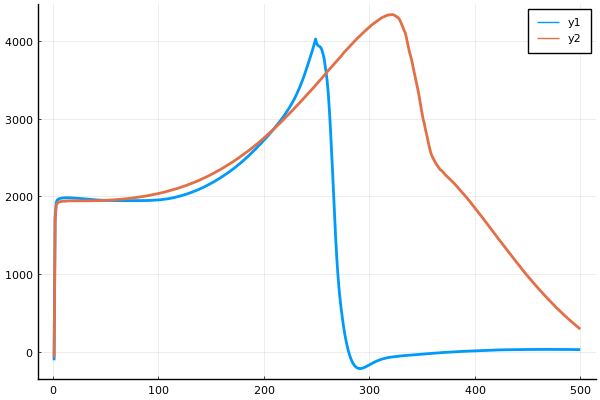

In [67]:
t = 1000
data = data_50_dk
sumu = data_50_dk[1].u[:,:,t]
for i = 2:t
    sumu += data[1].u[:,:,t]
end

plot(mean(data[1].z[:,:,1]-data[1].z[:,:,t]+sumu,dims=2),linewidth=2)

# if false
# sumu = data_200[1].u[:,:,1]
# for i = 2:t
#     sumu += data_50[1].u[:,:,t]
# end

# plot!(mean(data_200[1].z[:,:,1]-data_200[1].z[:,:,t]+sumu,dims=2),linewidth=2)

sumu = data_inf[1].u[:,:,1]
for i = 2:t
    sumu += data_inf[1].u[:,:,t]
end

plot!(mean(data_inf[1].z[:,:,1]-data_inf[1].z[:,:,t]+sumu,dims=2),linewidth=2)
#plot(mean(data_50[1].z[:,:,1]-data_50[1].z[:,:,t]+sumu,dims=2),linewidth=2)


In [79]:
import ipyleaflet 


ArgumentError: [91mArgumentError: Package ipyleaflet not found in current path:[39m
[91m- Run `import Pkg; Pkg.add("ipyleaflet")` to install the ipyleaflet package.[39m


In [55]:
data = data_10

heatmap(data[1].z[:,:,t]- data[1].z[:,:,t-1]+data[1].z[:,:,t]-data[1].z[:,:,t-1],clim=(-10, 0))

UndefVarError: [91mUndefVarError: data_10 not defined[39m

In [ ]:
## Te 10 km 

lemur_params.flex = 10e3
lemur_params.t_c = 10000000000000000e6
data_inf = run_lemur.run(lemur_params)

In [ ]:
## Te 10 km 
lemur_params.flex = 10e3
lemur_params.t_c = 50e6
data_10 = run_lemur.run(lemur_params)

In [ ]:
lemur_params.t_c = 100000000000000000000000000000000000000e6
lemur_params.t = 10e6
lemur_params.dt = .1e6
data_100 = run_lemur.run(lemur_params)

In [ ]:
lemur_params.t_c = 200e6
lemur_params.t = 200e6 
lemur_params.dt = .2e6
data_200 = run_lemur.run(lemur_params)

In [ ]:
lemur_params.t_c = 200e6
data_1000 = run_lemur.run(lemur_params)

In [ ]:
## Te 10 km 

lemur_params.flex = 10e3
lemur_params.t_c = 10e6
data_10 = run_lemur.run(lemur_params)